In [25]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from pacmap import PaCMAP

patient_list = [28, 30, 31, 33, 34, 35, 37, 39]
mn_ratio = 30
fp_ratio = 15
lr = 0.05

In [26]:
# Initialize empty lists to store data from all patients
all_embeddings = []
all_start_times = []
all_stop_times = []
all_file_indices = []
all_window_indices = []
all_patient_ids = []

# Load and combine data from each patient
for patient_id in patient_list:
    # Load embeddings file
    embedding_path = f'output/jackal/Epat{patient_id}/embeddings_Epat{patient_id}_60win30str_train.pkl'
    with open(embedding_path, 'rb') as f:
        patient_data = pickle.load(f)
    
    # Append data while preserving order
    all_embeddings.append(patient_data['patient_embeddings'])
    all_start_times.extend(patient_data['start_times'])
    all_stop_times.extend(patient_data['stop_times'])
    all_file_indices.extend(patient_data['file_indices'])
    all_window_indices.extend(patient_data['window_indices'])
    all_patient_ids.extend([patient_id] * len(patient_data['start_times']))

# Combine embeddings arrays
combined_embeddings = np.vstack(all_embeddings)

# Create combined dictionary with same structure
combined_data = {
    'patient_id': all_patient_ids,
    'patient_embeddings': combined_embeddings,
    'start_times': all_start_times,
    'stop_times': all_stop_times,
    'file_indices': all_file_indices,
    'window_indices': all_window_indices,
    'original_shape': combined_embeddings.shape,
    'sleep_labels': None
}

with open('source_pickles/combined_data.pkl', 'wb') as f:
    pickle.dump(combined_data, f)

In [23]:
# Set up sleep tagging functions

def find_sleep_stage(start_time, stop_time, sleep_data, patient_id, certainty_threshold):
    """Find sleep stage for a given time window and patient."""
    patient_sleep = sleep_data[
        (sleep_data['PatID'] == patient_id) & 
        (sleep_data['AvgCertainty'] >= certainty_threshold)
    ]
    
    if len(patient_sleep) == 0:
        return 'unknown'
    
    # Check for overlapping sleep stages
    overlapping_stages = patient_sleep[
        (patient_sleep['OnsetDatetime'] <= stop_time) & 
        (patient_sleep['OffsetDatetime'] >= start_time)
    ]
    
    if len(overlapping_stages) > 0:
        sleep_stage = overlapping_stages.iloc[0]['SleepCat']
        # Group N2 and N3 into N
        return 'N' if sleep_stage in ['N2', 'N3'] else sleep_stage
    return 'unknown'


def tag_points(patient_list, sleep_data, certainty_threshold):
    """Tag points with sleep stage metadata and update combined_data.pkl."""
    print("\nLoading combined data...")
    with open('source_pickles/combined_data.pkl', 'rb') as f:
        data = pickle.load(f)
    
    # Debug: check the format of stored patient IDs
    print("\nSample of patient IDs in data:", data['patient_id'][:5])
    print("Type of first patient ID:", type(data['patient_id'][0]))
    
    print("\nProcessing patient data...")
    sleep_stages = []
    
    # Get unique patient IDs
    unique_patients = sorted(patient_list)
    print(f"Found {len(unique_patients)} patients in data")
    
   # Process each patient's points
    for pat_id in unique_patients:
        print(f"\nTagging sleep stages for Epat{pat_id}")
        
        # Get indices for this patient's points
        pat_mask = np.array([pat_id == pid for pid in data['patient_id']])
        print(f"Number of points for patient {pat_id}: {sum(pat_mask)}")
        
        # Get this patient's sleep metadata
        pat_sleep = sleep_data[
            (sleep_data['PatID'] == f"Epat{pat_id}") & 
            (sleep_data['AvgCertainty'] >= certainty_threshold)
        ]
        
        if len(pat_sleep) == 0:
            print(f"No sleep events found for Epat{pat_id}")
            pat_stages = ['unknown'] * sum(pat_mask)
            print(f"Added {len(pat_stages)} 'unknown' labels")
        else:
            print(f"Found {len(pat_sleep)} sleep events")
            pat_stages = []
            
            # Get file start times for this patient
            file_starts = np.array(data['start_times'])[pat_mask]
            file_stops = np.array(data['stop_times'])[pat_mask]
            
            # For each file
            for file_start, file_stop in zip(file_starts, file_stops):
                # Calculate window start times using 30-second stride
                window_starts = [file_start + pd.Timedelta(seconds=30*i) for i in range(32)]
                window_stops = [start + pd.Timedelta(seconds=60) for start in window_starts]  # 60-second windows
                
                # Get sleep stage for each window
                for window_start, window_stop in zip(window_starts, window_stops):
                    stage = find_sleep_stage(window_start, window_stop, sleep_data, f"Epat{pat_id}", certainty_threshold)
                    pat_stages.append(stage)
            
            print(f"Added {len(pat_stages)} labels")
        
        sleep_stages.extend(pat_stages)
        print(f"Total labels so far: {len(sleep_stages)}")
    
    # Print summary statistics
    stage_counts = pd.Series(sleep_stages).value_counts()
    print("\nSleep stage distribution:")
    for stage, count in stage_counts.items():
        print(f"{stage}: {count}")
    
    # Update sleep_labels in combined data
    data['sleep_labels'] = sleep_stages
    print("\nSleep labels shape:", np.array(data['sleep_labels']).shape)
    print("Patient embeddings shape:", data['patient_embeddings'].shape)
    
    # Save updated combined data
    print("\nSaving updated combined data...")
    with open('source_pickles/combined_data.pkl', 'wb') as f:
        pickle.dump(data, f)

In [4]:
# Load sleep metadata
sleep_data = pd.read_excel('metadata/cleaned_sleep.xlsx')

# Convert datetime columns
sleep_data['OnsetDatetime'] = pd.to_datetime(sleep_data['OnsetDatetime'])
sleep_data['OffsetDatetime'] = pd.to_datetime(sleep_data['OffsetDatetime'])

In [5]:
tag_points(patient_list, sleep_data, 0.6)

with open('source_pickles/combined_data.pkl', 'rb') as f:
    combined_data = pickle.load(f)

embeddings = combined_data['patient_embeddings']
print("Embeddings shape:", embeddings.shape)
flat_embeddings = embeddings.reshape(-1, embeddings.shape[-1])
print("Reshaped embeddings shape:", flat_embeddings.shape)

sleep_labels = combined_data['sleep_labels']
print('Sleep labels shape:', len(sleep_labels))
print(sleep_labels)


Loading combined data...

Sample of patient IDs in data: [28, 28, 28, 28, 28]
Type of first patient ID: <class 'int'>

Processing patient data...
Found 5 patients in data

Tagging sleep stages for Epat28
Number of points for patient 28: 896
Found 5 sleep events
Added 28672 labels
Total labels so far: 28672

Tagging sleep stages for Epat30
Number of points for patient 30: 760
Found 12 sleep events
Added 24320 labels
Total labels so far: 52992

Tagging sleep stages for Epat31
Number of points for patient 31: 640
Found 14 sleep events
Added 20480 labels
Total labels so far: 73472

Tagging sleep stages for Epat37
Number of points for patient 37: 720
Found 15 sleep events
Added 23040 labels
Total labels so far: 96512

Tagging sleep stages for Epat39
Number of points for patient 39: 648
Found 3 sleep events
Added 20736 labels
Total labels so far: 117248

Sleep stage distribution:
unknown: 115320
N: 1143
W: 639
R: 146

Sleep labels shape: (117248,)
Patient embeddings shape: (3664, 32, 512)



In [6]:
pacmap_params = {
    'n_components': 2,
    'MN_ratio': 12,
    'FP_ratio': 10,
    'distance': 'angular',
    'verbose': True,
    'lr': 0.05,
    'num_iters': 900
}

project_to_2d = PaCMAP(**pacmap_params)
manifold_2d = project_to_2d.fit_transform(flat_embeddings)

Applied PCA, the dimensionality becomes 100
PaCMAP(n_neighbors=10, n_MN=120, n_FP=100, distance=angular, lr=0.05, n_iters=(100, 100, 900), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((1172480, 2), (14069760, 2), (11724800, 2))
Initial Loss: 7674297.5
Iteration:   10, Loss: 6084094.000000
Iteration:   20, Loss: 6083175.000000
Iteration:   30, Loss: 5712049.500000
Iteration:   40, Loss: 5342701.000000
Iteration:   50, Loss: 4898809.500000
Iteration:   60, Loss: 4501828.000000
Iteration:   70, Loss: 4103717.000000
Iteration:   80, Loss: 3601283.000000
Iteration:   90, Loss: 2939271.250000
Iteration:  100, Loss: 1996307.375000
Iteration:  110, Loss: 1716044.375000
Iteration:  120, Loss: 1514529.375000
Iteration:  130, Loss: 1376278.750000
Iteration:  140, Loss: 1286282.500000
Iteration:  150, Loss: 1226399.000000
Iteration:  160, Loss: 1183573.000000
Iter

Shape of manifold_2d: (117248, 2)
Length of sleep_labels: 117248
Unique sleep labels: ['N' 'R' 'W' 'unknown']
Number of unlabeled points: 115320

Label: W
Number of points with this label: 639

Label: N
Number of points with this label: 1143

Label: R
Number of points with this label: 146


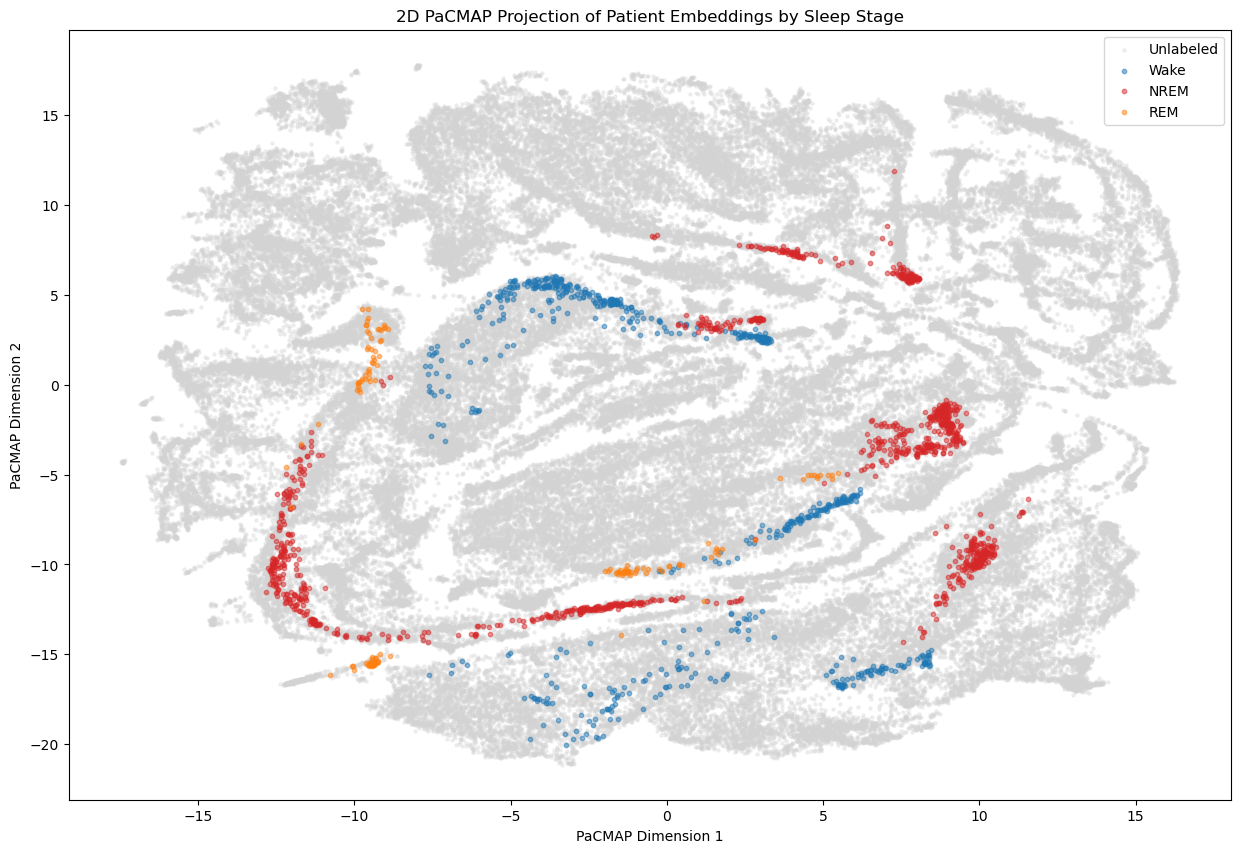

In [7]:
# First make sure matplotlib is imported
import matplotlib.pyplot as plt

# Add debug prints to check data
print("Shape of manifold_2d:", manifold_2d.shape)
print("Length of sleep_labels:", len(sleep_labels))
print("Unique sleep labels:", np.unique(sleep_labels))

plt.figure(figsize=(15,10))

# Plot unlabeled points in grey first
labeled_mask = np.isin(sleep_labels, ['W', 'N', 'R'])
print("Number of unlabeled points:", np.sum(~labeled_mask))
plt.scatter(manifold_2d[~labeled_mask,0], manifold_2d[~labeled_mask,1],
           c='lightgray', alpha=0.3, s=5, label='Unlabeled')

sleep_colors = {
    'W': '#1f77b4',  # blue
    'N': '#d62728',  # red
    'R': '#ff7f0e'   # orange
}
sleep_names = {
    'W': 'Wake',
    'N': 'NREM',
    'R': 'REM'
}

# Plot labeled points on top
for label in sleep_colors:
    mask = np.array(sleep_labels) == label
    print(f"\nLabel: {label}")
    print(f"Number of points with this label: {np.sum(mask)}")
    if np.any(mask):
        plt.scatter(manifold_2d[mask,0], manifold_2d[mask,1],
                   c=sleep_colors[label],
                   label=sleep_names[label],
                   alpha=0.5, s=10)

plt.title('2D PaCMAP Projection of Patient Embeddings by Sleep Stage')
plt.xlabel('PaCMAP Dimension 1')
plt.ylabel('PaCMAP Dimension 2')
plt.legend()
plt.show()  # Explicitly call show()

In [32]:
embeddings = combined_data['patient_embeddings']
print("Embeddings shape:", embeddings.shape)
flat_embeddings = embeddings.reshape(-1, embeddings.shape[-1])
print("Reshaped embeddings shape:", flat_embeddings.shape)

pacmap_params = {
    'n_components': 2,
    'MN_ratio': 30,
    'FP_ratio': 30,
    'distance': 'angular',
    'verbose': True,
    'lr': 0.05,
    'num_iters': 900
}

project_to_2d = PaCMAP(**pacmap_params)
manifold_2d = project_to_2d.fit_transform(flat_embeddings)

Embeddings shape: (5160, 32, 512)
Reshaped embeddings shape: (165120, 512)
Applied PCA, the dimensionality becomes 100
PaCMAP(n_neighbors=10, n_MN=300, n_FP=300, distance=angular, lr=0.05, n_iters=(100, 100, 900), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((1651200, 2), (49536000, 2), (49536000, 2))
Initial Loss: 10790761.0
Iteration:   10, Loss: 12904886.000000
Iteration:   20, Loss: 14764457.000000
Iteration:   30, Loss: 14344008.000000
Iteration:   40, Loss: 13799620.000000
Iteration:   50, Loss: 13470875.000000
Iteration:   60, Loss: 13162285.000000
Iteration:   70, Loss: 12692492.000000
Iteration:   80, Loss: 11266346.000000
Iteration:   90, Loss: 9108608.000000
Iteration:  100, Loss: 6064468.000000
Iteration:  110, Loss: 5200073.500000
Iteration:  120, Loss: 4486546.000000
Iteration:  130, Loss: 4083744.250000
Iteration:  140, Loss: 3824680.250

5160
5160
Shape of manifold_2d: (165120, 2)
Length of expanded patient IDs: 165120
Shape of original patient embeddings: (5160, 32, 512)


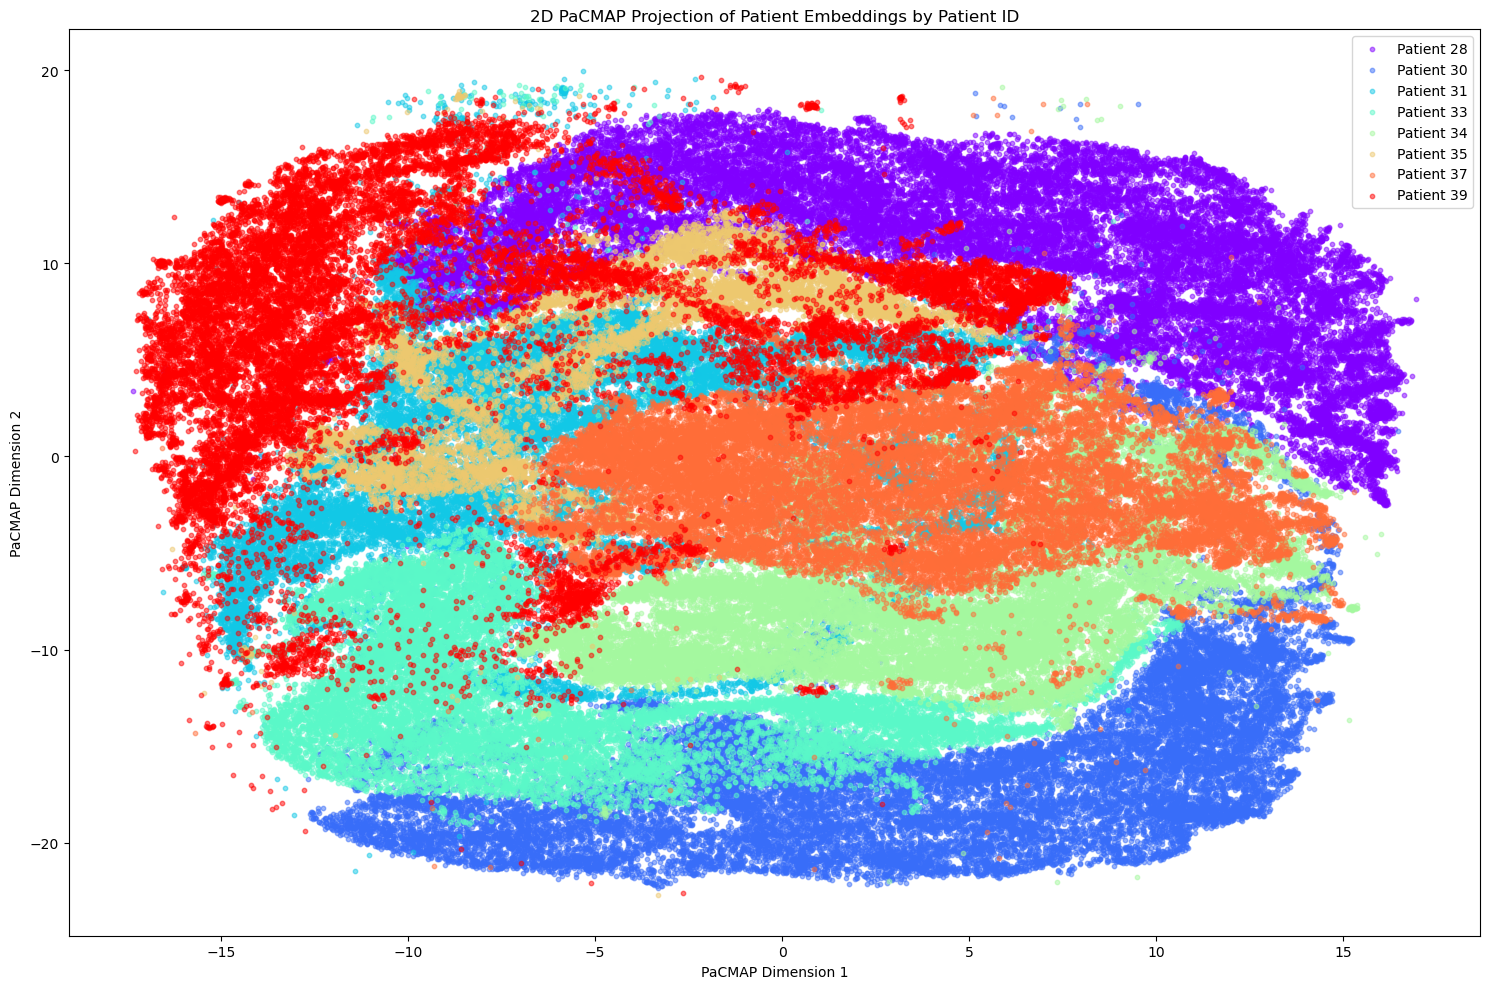

In [33]:
# Load the combined data if not already loaded
with open('source_pickles/combined_data.pkl', 'rb') as f:
    combined_data = pickle.load(f)

print(len(combined_data['patient_embeddings']))
print(len(combined_data['patient_id']))

# Expand patient IDs to match the flattened structure
expanded_patient_ids = np.repeat(combined_data['patient_id'], 32)

plt.figure(figsize=(15,10))

# Add debug prints to check data shapes
print("Shape of manifold_2d:", manifold_2d.shape)
print("Length of expanded patient IDs:", len(expanded_patient_ids))
print("Shape of original patient embeddings:", combined_data['patient_embeddings'].shape)

# Create a color map for unique patient IDs
unique_patients = sorted(set(expanded_patient_ids))
n_patients = len(unique_patients)
colors = plt.cm.rainbow(np.linspace(0, 1, n_patients))

# Plot points for each patient with a different color
for idx, patient_id in enumerate(unique_patients):
    mask = (expanded_patient_ids == patient_id)  # Create boolean mask
    if len(mask) != manifold_2d.shape[0]:
        print(f"Warning: mask length ({len(mask)}) doesn't match manifold_2d length ({manifold_2d.shape[0]})")
        continue
        
    plt.scatter(manifold_2d[mask,0], manifold_2d[mask,1],
               c=[colors[idx]], 
               label=f'Patient {patient_id}',
               alpha=0.5, s=10)

plt.title('2D PaCMAP Projection of Patient Embeddings by Patient ID')
plt.xlabel('PaCMAP Dimension 1')
plt.ylabel('PaCMAP Dimension 2')

# Adjust legend if there are many patients
if n_patients > 10:
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
else:
    plt.legend()

plt.tight_layout()
plt.savefig(f'figures/multipatient_space_Epat28_30_31_37_39.svg', format='svg', bbox_inches='tight')

In [15]:
plt.savefig(f'figures/multipatient_space_Epat28_30_31_37_39.svg', format='svg', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>